# ch4  
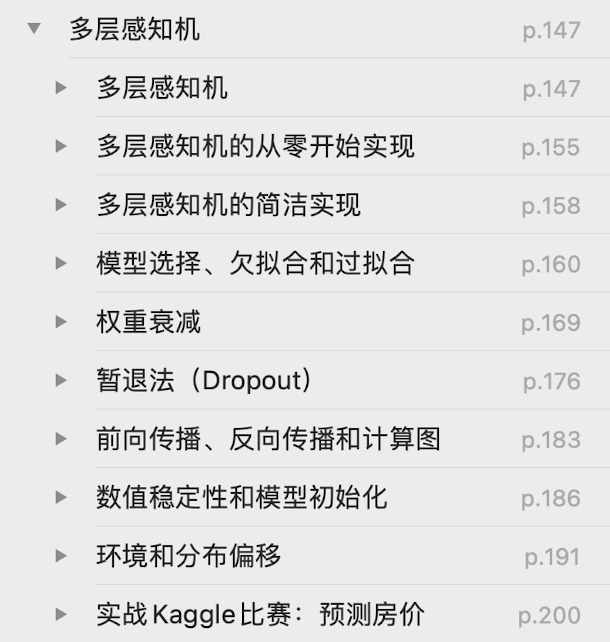

In [9]:
%matplotlib inline
import torch
import d2l.torch as d2l
from torch import nn
import math
import numpy as np

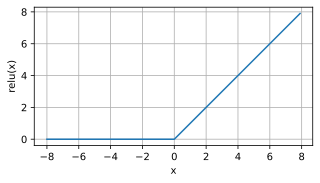

In [10]:
x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach().numpy(),y.detach().numpy(),'x','relu(x)',figsize=(5,2.5))

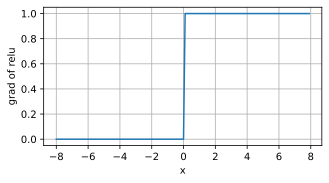

In [11]:
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of relu',figsize=(5,2.5))

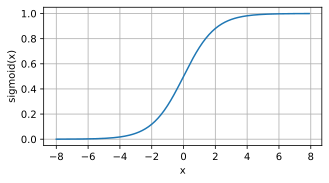

In [12]:
y = torch.sigmoid(x)
d2l.plot(x.detach(),y.detach(),'x','sigmoid(x)',figsize=(5,2.5))

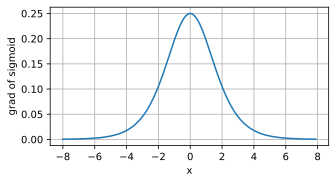

In [13]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of sigmoid',figsize=(5,2.5))

$ \mathrm{tanh(x)} = \frac{1- \exp(-2x)}{1 + \exp(-2x)} $

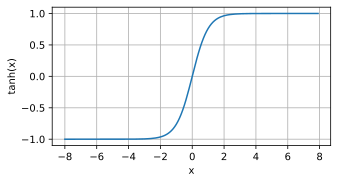

In [14]:
y = torch.tanh(x)
d2l.plot(x.detach(),y.detach(),'x','tanh(x)',figsize=(5,2.5))

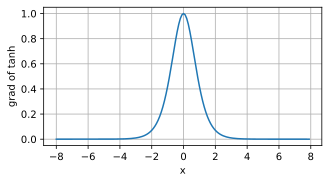

In [15]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of tanh',figsize=(5,2.5))

## 4.2 多层感知机从零开始

In [16]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

In [17]:
num_inputs,num_outputs,num_hiddens = 784,10,256

W1 = nn.Parameter(torch.randn(
    num_inputs,num_hiddens,requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens,num_outputs,requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

In [18]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)

In [19]:
def net(X):
    X = X.reshape((-1,num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

In [20]:
loss = nn.CrossEntropyLoss(reduction='none')

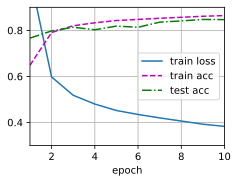

In [21]:
num_epochs,lr = 10,0.1
updater = torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)

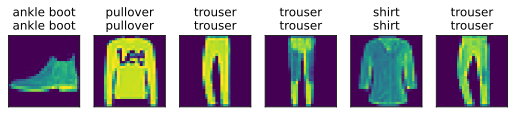

In [22]:
d2l.predict_ch3(net,test_iter)

## 4.3 多层感知机的简洁实现

In [23]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Linear(256,10)
)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [24]:
batch_size,lr,num_epochs = 256,0.1,10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=lr)

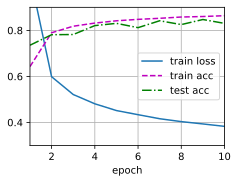

In [25]:
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

## 4.4.4 多项式回归

In [26]:
max_degree = 20
n_train,n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train + n_test ,1))
np.random.shuffle(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1)) # 广播机制 每项取20次幂
for i in range(max_degree):
    poly_features[:,] /= math.gamma(i+1)  # gamma(n)=(n-1)! # 每项按照阶乘缩放
# labels的维度：(n_train + n_test,)
labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape) #scale=0.1 缩放因子 标准差变为0.1

In [27]:
true_w,features,poly_features,labels = [torch.tensor(x,dtype=torch.float32 ) 
                            for x in [true_w,features,poly_features,labels]]

In [28]:
features[:2],poly_features[:2,:],labels[:2]

(tensor([[-0.2409],
         [-0.6840]]),
 tensor([[0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.],
         [0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.]]),
 tensor([ 0.0612, -0.1489]))

In [29]:
def evaluate_loss(net,data_iter,loss):
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [30]:
def train(train_features,test_features,train_labels,test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(
        nn.Linear(input_shape,1,bias=False)
        )
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),
                                batch_size,is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
                            xlim=[1,num_epochs],ylim=[1e-3,1e2],
                            legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch ==0 or (epoch + 1)%20==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                  evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

weight: [[-0.3491177   0.27906132  0.4994774  -0.1705544 ]]


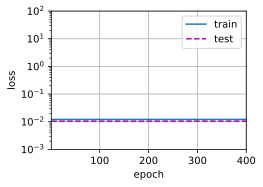

In [31]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
'''-
输入特征训练集，为二维张量，其中包含了前‘n_train’个样本的特征

'''
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
      labels[:n_train],labels[n_train:])#?

weight: [[-0.30724883 -0.02494258]]


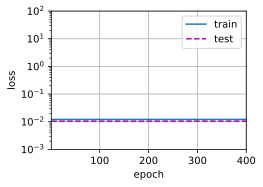

In [32]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],
      labels[:n_train],labels[n_train:])
#? 代码曲线 奇怪得很 下次再看 不如直接看有问题的地方了
# 难搞 因为真的很多不明白的

In [69]:
# 列表的切片还真是奇奇怪怪
'''-
poly_features[:n_train,:1]
      =poly_features[0:n_train,0:1]
      输入特征的训练集，二维张量，包含了前‘n_train’个样本和第一列（列索引为0）的数据
      行索引从0到’n_train - 1‘
poly_features[n_train:,:] 
      输入特征的测试集，包含了从第n_train个样本到最后一个样本的特征
labels[:n_train]
      训练集标签，即与训练集中每个样本对应的目标值
labels[n_train:]
      测试集标签，即与测试集中每个样本对应的目标值
'''
help(train)
train(poly_features[:n_train,:1],poly_features[n_train:,:],
      labels[:n_train],labels[n_train:])

Help on function train in module __main__:

train(lambd)



TypeError: train() takes 1 positional argument but 4 were given

# 4.5 权重衰减

In [34]:
n_train,n_test,num_inputs,batch_size=20,100,200,5
true_w,true_b = torch.ones((num_inputs,1))*0.01,0.05

train_data = d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data,batch_size)

test_data = d2l.synthetic_data(true_w,true_b,n_test)
test_iter = d2l.load_array(test_data,batch_size,is_train=False)

## 4.5.2 从零开始实现

In [35]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

In [36]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [37]:
def train(lambd):
    w,b = init_params()
    net,loss = lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.003
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                            xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch + 1) %5 ==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                                  d2l.evaluate_loss(net,test_iter,loss)))
            
    print('w的L2范数是：',torch.norm(w).item())

w的L2范数是： 13.476705551147461


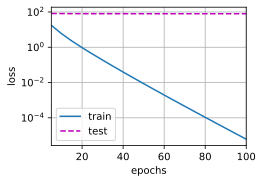

In [38]:
train(lambd=0)

w的L2范数是： 0.32890695333480835


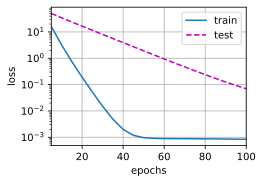

In [39]:
train(lambd=3)

In [40]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs,lr=100,0.003

    trainer = torch.optim.SGD([
        {'params':net[0].weight,'weight_decay':wd},
        {'params':net[0].bias}
    ],lr=lr)

    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                            xlim=[5,num_epochs],legend=['train','test'])
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if (epoch+1)%5 == 0:
            animator.add(epoch+1,
                         (d2l.evaluate_loss(net,train_iter,loss),
                         d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数：',net[0].weight.norm().item())

w的L2范数： 13.303695678710938


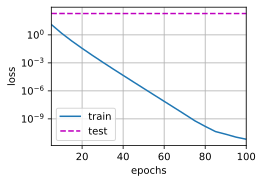

In [41]:
train_concise(0)

w的L2范数： 0.34275469183921814


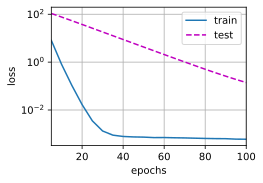

In [42]:
train_concise(3)

# 4.6.4 从零开始实现

In [43]:
def dropout_layer(X,dropout):
    '''
    这个断言语句确保 dropout 的值在 [0, 1] 的闭区间内。
    断言语句通常用于在代码中加入一些假设或先决条件，
    以便在运行时检查这些条件是否满足。如果条件不满足，将引发异常,
    帮助程序员在调试或运行时发现潜在的问题
    引发 AssertionError 异常
    '''
    # 先验条件
    assert 0 <= dropout <= 1
    # 所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 所有元素都被保留
    if dropout == 0:
        return X
    '''
    mask：二值掩码
    torch.rand(X.shape)：
    这部分代码生成了一个与输入张量 X 相同形状的随机张量，其中的值在 [0, 1) 之间均匀分布。
    (torch.rand(X.shape) > dropout)：
    这部分代码创建了一个布尔张量，其中的元素为 True，
    如果对应的随机数大于 dropout，否则为 False。
    '''
    mask = (torch.rand(X.shape) > dropout).float()
    '''
    mask * X：
    这部分代码将输入张量 X 中的元素与掩码 mask 逐元素相乘。
    
    掩码中为 1 的位置的元素保持不变，而为 0 的位置的元素被置零，实现了 dropout 操作。
    
    / (1.0 - dropout)：
    这部分代码对整个结果进行缩放，以补偿 dropout 操作可能引入的缩小。
    这是为了保持期望值的不变，确保在训练和推断时具有相似的统计性质
    '''
    return mask * X / (1.0 - dropout)
    

In [44]:
# 测试dropout层函数的功能 dropout_layer(X,dropout)
X = torch.arange(16,dtype=torch.float32).reshape((2,8))
print(X)
# 丢弃率=0 所有元素全部保留
print(dropout_layer(X,0.))
# 丢弃率=0.5 丢弃16*0.5 = 8个元素 剩余元素 ÷ 0.5
print(dropout_layer(X,0.5))
# 丢弃率=0.1 丢弃16*0.1个元素 剩余元素÷0.9
print(dropout_layer(X,0.1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  0., 10.,  0.,  0.],
        [16., 18., 20., 22.,  0., 26., 28.,  0.]])
tensor([[ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778],
        [ 8.8889,  0.0000, 11.1111, 12.2222, 13.3333, 14.4444, 15.5556, 16.6667]])


In [45]:
num_inputs,num_outputs,num_hiddens1,num_hiddens2 = 784,10,256,256
'''
暂退法：
①应用于每个隐藏层的输出
②靠近输入层的地方设置较低的丢弃率
③暂退法只在训练期间有效
'''
dropout1 = 0.2
dropout2 = 0.5

class Net(nn.Module):
    def __init__(self,num_inputs,num_outputs,num_hiddens1,num_hiddens2,is_training=True):
        super(Net,self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs,num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1,num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2,num_outputs)
        self.relu = nn.ReLU()
    def forward(self,X):
        # 第一个隐藏层=对第一个线性层进行dropout
        # 训练第一个隐藏层 进行线性层以后用relu激活函数激活
        H1 = self.relu(self.lin1(X.reshape((-1,self.num_inputs))))
        # 如果是训练集则进行dropout
        if self.training == True:
            H1 = dropout_layer(H1,dropout1)
        H2 = self.relu(self.lin2(H1))
        # 如果是训练模式还需要进行dropout
        if self.training == True:
            H2 = dropout_layer(H2,dropout2)
        # 输出
        out = self.lin3(H2)

        return out

net = Net(num_inputs,num_outputs,num_hiddens1,num_hiddens2)  

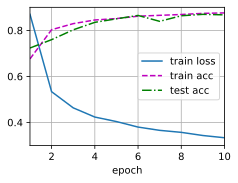

In [46]:
import d2l.torch as d2l

num_epochs,lr,batch_size = 10,0.5,256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

# 4.6.5 简洁实现

In [47]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    # 在第一个全连接层后添加一个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256,256),
                    nn.ReLU(),
                    # 在第二个全连接层后添加一个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256,10))

def init_weights(m):
    '''-
    def init_weights(m):
        这是一个函数定义，定义了一个函数名为 init_weights，该函数接受一个参数 m。
    if type(m) == nn.Linear:
        这是一个条件语句，检查参数 m 是否是 PyTorch 中的线性层（nn.Linear）
        nn.init.normal_(m.weight, std=0.01)：
        如果 m 是线性层，那么使用 nn.init.normal_ 函数对该线性层的权重进行初始化。
        nn.init.normal_ 会将权重初始化为均值为0、标准差为 std=0.01 的正态分布中的随机值。
    
    这个函数的主要目的是对神经网络中的线性层进行权重初始化。
    '''
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

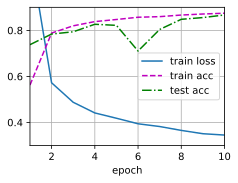

In [48]:
trainer = torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

# 梯度消失

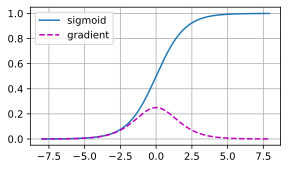

In [ ]:
x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y = torch.sigmoid(x)
# 加一行这个=计算梯度
'''-
.backward()：这是 PyTorch 中的自动微分函数，
用于计算关于计算图中叶子节点的梯度。
在这里，y.backward() 表示计算 y 相对于计算图中所有叶子节点（通常是模型参数）的梯度。
============
torch.ones_like(x)：这是一个与输入张量 x 具有相同形状的张量，
所有元素的值都设为1。
这个张量会用作 .backward() 方法的参数，以确定梯度计算的缩放因子。
通过乘以这个张量，可以对梯度进行缩放，这在某些情况下可能很有用。
============
y.backward(torch.ones_like(x)) 的效果是
计算模型输出或损失函数 y 相对于计算图中所有叶子节点（通常是模型参数）的梯度，
并使用全为1的张量进行缩放。
这是典型的反向传播操作，用于在训练深度学习模型时计算梯度并更新模型参数。
'''
y.backward(torch.ones_like(x))

# 一个x对应的两个y值 用列表给出 legend图例也是
d2l.plot(x.detach().numpy(),[y.detach().numpy(),x.grad.numpy()],
         legend=['sigmoid','gradient'],figsize=(4.5,2.5))

# 梯度爆炸

In [ ]:
M = torch.normal(0,1,size=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    # 100个随机高斯矩阵相乘
    M = torch.mm(M,torch.normal(0,1,size=(4,4)))
print('乘以100个矩阵以后\n',M)

一个矩阵 
 tensor([[ 1.1722, -0.1765,  0.9882,  0.8345],
        [ 1.0884, -1.9029,  1.5755,  1.0159],
        [-0.3645,  1.2966, -0.0421,  1.5057],
        [ 0.5727, -2.5333, -0.6661,  1.8045]])
乘以100个矩阵以后
 tensor([[ 7.2148e+23, -2.9917e+24, -5.0404e+24, -2.6071e+24],
        [ 3.6345e+23, -1.5071e+24, -2.5391e+24, -1.3134e+24],
        [-1.0104e+23,  4.1895e+23,  7.0585e+23,  3.6510e+23],
        [-9.8099e+23,  4.0678e+24,  6.8533e+24,  3.5449e+24]])


# Kaggle 预测房价

In [94]:
import hashlib
import os
import tarfile
import zipfile
import requests
import pandas as pd

In [95]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


In [96]:
def download(name,cache_dir=os.path.join('..','data')):
    # 下载一个DATA_HUB中的文件，返回本地文件名

    # 这是一个断言语句，用于确保要下载的文件名 name 存在于预定义的 DATA_HUB 字典中。如果不存在，将引发 AssertionError 异常。
    assert name in DATA_HUB,f"{name} 不存在于 {DATA_HUB}"
    # 从 DATA_HUB 中获取文件名为 name 的条目，其中包含文件的下载 URL 和 SHA-1 哈希值。
    url,sha1_hash = DATA_HUB[name]
    # 创建缓存目录，如果目录已存在则不会引发异常。
    os.makedirs(cache_dir,exist_ok=True)
    # 生成本地文件名，将缓存目录和下载 URL 的文件名部分结合而成。
    fname = os.path.join(cache_dir,url.split('/')[-1])
    # 检查本地是否已经存在相应的文件。
    if os.path.exists(fname):
        # 创建 SHA-1 哈希对象，用于验证文件完整性。
        sha1 = hashlib.sha1()
        # 打开本地文件，以二进制模式读取文件内容。
        with open(fname,'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return name
    print(f'正在从{url}下载{fname}...')
    # 使用 requests 库向指定的 URL 发起 GET 请求，
    # stream=True 表示以流式方式下载文件，
    # verify=True 表示验证 SSL 证书。
    r = requests.get(url,stream=True,verify=True)
    # 以二进制模式写入下载的文件内容到本地文件。
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname # 返回本地文件名，表示下载成功。

'''这个函数的主要目的是从指定的 DATA_HUB 中下载文件，
确保文件的完整性，并将文件保存到本地缓存目录。
如果文件已经存在且哈希值匹配，将直接返回本地文件名。
如果文件不存在或者哈希值不匹配，则会从 URL 下载文件，并返回本地文件名。'''

'这个函数的主要目的是从指定的 DATA_HUB 中下载文件，\n确保文件的完整性，并将文件保存到本地缓存目录。\n如果文件已经存在且哈希值匹配，将直接返回本地文件名。\n如果文件不存在或者哈希值不匹配，则会从 URL 下载文件，并返回本地文件名。'

In [97]:
def download_extract(name,folder=None):
    # 下载并解压zip/tar文件
    # 使用先前定义的 download 函数下载文件，并得到本地文件名。
    fname = download(name)
    # 获取 fname 的目录部分，作为基础目录。
    base_dir = os.path.dirname(fname)
    # 将文件名和扩展名分开，以便后面的判断使用。
    data_dir,ext = os.path.splitext(fname)
    if ext == '.zip':
        # 如果文件类型是 .zip，则使用 zipfile.ZipFile 打开文件
        fp = zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'):
        # 如果文件类型是 .tar 或 .gz，则使用 tarfile.open 打开文件。
        fp = tarfile.open(fname,'r')
    else:
        # 否则，如果文件类型不是 .zip、.tar 或 .gz，使用 assert False 抛出异常，
        # 这可能是一个错误。
        # 使用相应的解压工具（zipfile 或 tarfile）将文件解压到基础目录。
        assert False,fp.extractall(base_dir)
    # 返回解压后的数据目录。
    # 如果提供了 folder 参数，则返回基础目录和指定的文件夹名称的组合，
    # 否则返回解压后的数据目录。
    return os.path.join(base_dir,folder) if folder else data_dir

def download_all():
    # 下载DAT_HUB中所有的文件
    for name in DATA_HUB:
        # 使用 for 循环遍历 DATA_HUB 中的所有文件名，
        # 并对每个文件名调用 download 函数，下载对应的文件。
        download(name)

'''
summary
download_all 可以下载 DATA_HUB 中所有文件，
download_extract 可以下载并解压指定文件，返回解压后的数据目录。
'''

'\nsummary\ndownload_all 可以下载 DATA_HUB 中所有文件，\ndownload_extract 可以下载并解压指定文件，返回解压后的数据目录。\n'

In [98]:
DATA_HUB['kaggle_house_train'] =(DATA_URL +'kaggle_house_pred_train.csv','585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL +'kaggle_house_pred_test.csv','fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [99]:
# 使用pandas分别加载训练数据和测试数据的csv文件
# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')

In [100]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [111]:
# 看前四个和最后两个特征 以及相应标签（房价
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])
print(train_data['SalePrice'])
SalePrice = train_data['SalePrice']

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


In [104]:
# 第一个特征是ID，不携带任何信息，删除
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features.shape

(2919, 79)

## 处理数值特征

In [106]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
'''-标准化和缺失值
all_features.dtypes：获取每一列的数据类型
all_features.dtypes != 'object' 比较数据类型是否为'object'，得到一个布尔类型的Series，指示每一列是否为数值类型
numeric_features 获取所有数据类型为数值特征的列索引
'''
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std())
)
'''-
all_features[numeric_features] 选择数据集中所有数值特征的列
.apply(
    lambda x:(x-x.mean())/(x.std()) 对每一列应用一个匿名函数 执行标准化操作 
            每个元素减去列均值÷列标准差
'''
all_features[numeric_features] = all_features[numeric_features].fillna(0)
'''-
使用0填充数值特征中的缺失值 处理标准化后可能产生的缺失值，将其填充为0
'''


'-\n使用0填充数值特征中的缺失值 处理标准化后可能产生的缺失值，将其填充为0\n'

## 处理离散值：独热编码
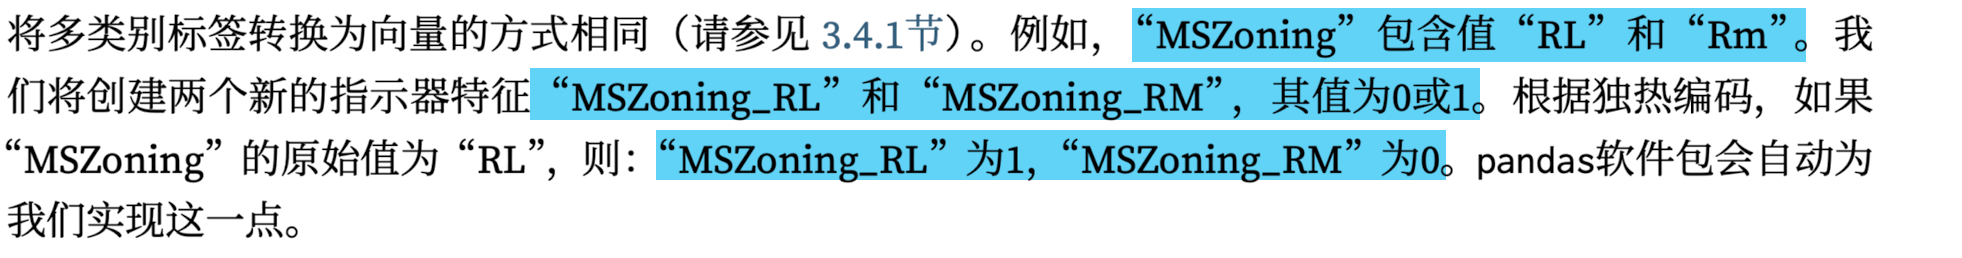

In [107]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape,all_features.dtypes
# 此转换将特征总数量从79增加到330个

((2919, 330),
 MSSubClass               float64
 LotFrontage              float64
 LotArea                  float64
 OverallQual              float64
 OverallCond              float64
                           ...   
 SaleCondition_Alloca        bool
 SaleCondition_Family        bool
 SaleCondition_Normal        bool
 SaleCondition_Partial       bool
 SaleCondition_nan           bool
 Length: 330, dtype: object)

In [108]:
bool_columns = all_features.select_dtypes(include='bool').columns
all_features[bool_columns] = all_features[bool_columns].astype(int)
all_features.dtypes


MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca       int64
SaleCondition_Family       int64
SaleCondition_Normal       int64
SaleCondition_Partial      int64
SaleCondition_nan          int64
Length: 330, dtype: object

In [109]:
train_data['ScalePrice']

KeyError: 'ScalePrice'

In [112]:
# 通过values属性，从pandas格式中提取NumPy格式，并将其转换为张量用于训练
# 获取训练数据集的样本数量，即训练集的行数。
n_train = train_data.shape[0]
'''
torch.tensor(all_features[:n_train].values,
    使用 Pandas DataFrame 的切片和 values 属性，
    提取前 n_train 行的数据，并将其转换为 NumPy 数组。
dtype=torch.float32
    将 NumPy 数组转换为 PyTorch 张量，并指定数据类型为 32 位浮点数。    
    '''
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float32)
# 提取测试集的数据并转换为 PyTorch 张量。
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float32)
'''-
train_data.ScalePrice.values：
    获取训练数据集中 ScalePrice 列的值，返回一个 NumPy 数组。
.reshape(-1, 1)：
    将该数组重新形状为一个列向量，即每个元素都在一列中。
torch.tensor(..., dtype=torch.float32)：
    将 NumPy 数组转换为 PyTorch 张量，并指定数据类型为 32 位浮点数。
'''
train_labels = torch.tensor(
    SalePrice.values.reshape(-1,1),dtype=torch.float32
)

In [113]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [114]:
def log_rmse(net,features,labels):
    # 为了在取对数时进一步稳定数值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    rmse  =torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [115]:
# 训练 损失 优化
def train(net,train_features,train_labels,tets_features,test_labels,
          num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    # 使用Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                lr = learning_rate,
                                 weight_decay = weight_decay )
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [116]:
# k折交叉验证
# 功能：实现k折交叉验证，从数据集中获取第i折的训练集和验证集
def get_k_fold_data(k,i,X,y):
    # k：折数  i：当前折的索引 X：输入特征的张量 y：标签的张量
    assert k>1
    # 前提条件 不满足报错AssertionError
    fold_size = X.shape[0] // k
    # 计算每一折的大小（样本数）
    X_train,y_train = None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        # 使用切片操作‘slice’获取当前折的索引范围
        X_part,y_part = X[idx,:],y[idx]
        # 从输入特征和标签中获取当前折的数据
        if j==i:
            # 如果当前折的索引=要提取的验证集所在折的索引，则将数据保存为验证集
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            # 如果当前折的索引不等于验证集所在折的索引，（且训练集还未初始化？）
            # 则将当前折的数据赋值给训练集
            X_train,y_train = X_part,y_part
        else:
            # 如果当前折不是验证集所在的折，（且训练集已经初始化，？）
            # 则将当前折的数据拼接到训练集中
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)
    # 最终函数返回训练集和验证集的输入特征和标签，重复k次，每次得到的训练集和验证集在不同的折中
    # 用于进行k折交叉验证 
    return X_train,y_train,X_valid,y_valid


In [117]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,
           batch_size):
    train_l_sum,valid_l_sum=0,0
    # 初始化训练集和验证集上损失的累计变量
    for i in range(k):
        # 循环进行k折交叉验证的训练和评估
        data = get_k_fold_data(k,i,X_train,y_train)
        # 获取第i折的训练集和验证集
        net = get_net()
        # 初始化神经网络
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,
                                  weight_decay,batch_size)
        # 调用train函数，进行模型训练，返回训练集和验证集上的损失
        train_l_sum += train_ls[-1]
        # 将当前折的训练集上最终损失累加到总训练损失
        valid_l_sum += valid_ls[-1]
        # 将当前折的验证集上最终损失累加到总验证损失
        if i == 0:
            # 只在第一折时绘制训练过程的损失曲线，并显示在标准输出
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],
                     xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                     legend=['train','valid'],yscale='log')
        print(f'折{i+1},训练log rmse {float(train_ls[-1]):f},'
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum /k, valid_l_sum / k
    # 返回训练集和验证集上损失的平均值
'''-summary：
该函数实现k折交叉验证的整体流程，通过训练和验证得到模型性能的估计
''' 

In [124]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,
                         batch_size=batch_size)
print(f'{k}-折验证：平均训练log rmse:{float(train_l):f},'
      f'平均验证log rmse:{float(valid_l):f}')

/Users/dearr/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([292, 1])) that is different to the input size (torch.Size([1459, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1459) must match the size of tensor b (292) at non-singleton dimension 0

# 提交kaggle结果

In [122]:
def train_and_pred(train_features,test_features,train_labels,test_labels,test_data,
                   num_epochs,lr,weight_decay,batch_size):
    net = get_net()
    train_ls,_ = train(net,train_features,train_labels,None,None,
                       num_epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',
             ylabel='log rmse',xlim=[1,num_epochs],yscale='log')
    print(f'训练 log rmse:{float(train_ls[-1]):f}')
    # 将网络应用于测试集
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导入到Kaggle
    test_data['ScalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['id'],test_data['ScalePrice']],axis=1)
    submission.to_csv('submission.csv',index=False)

In [123]:
train_and_pred(train_features,test_features,train_labels,test_data,
               num_epochs,lr,weight_decay,batch_size)

TypeError: train_and_pred() missing 1 required positional argument: 'batch_size'